In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
import math
import numpy as np
import glob
import csv
import sys
sys.path.append('/home/jbohm/start_tf/PointNet_Segmentation')
from pnet_models_updated import pnet_part_seg_no_tnets, pnet_part_seg

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt

In [2]:
# set GPU
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

# disable eager execution with tensorflow (since can't execute lambda functions with eager execution)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
# DATA AND OUTPUT DIRS
data_dir = '/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1' # parent directory that holds train, val, and test files
train_data_dir = data_dir + '/train/'
val_data_dir = data_dir + '/val/'
test_data_dir = data_dir + '/test/'

output_dir = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/tr_25_val_5_tst_5_lr_1e-2_BS_100_no_tnets" # save model and predictions to this dir
max_points_file = '/max_points.txt' # load the max number of points in a sample

num_train_files = 25
num_val_files = 5
num_test_files = 5
events_per_file = 6000 # approx number of samples in a file
start_at_epoch = 0 # to load a pre trained model from this epoch

EPOCHS = 5
BATCH_SIZE = 100
LEARNING_RATE = 1e-2
add_min_dist = True

In [4]:
# DATA GENERATORS
def batched_data_generator(file_names, batch_size, max_num_points, loop_infinite=True, add_min_track_dist=False):
    while True:
        for file in file_names:
            point_net_data = np.load(file)
            event_data = point_net_data['X']
            Y = point_net_data['Y']

            # pad X and Y data to have y dimension of max_num_points
            X_padded = np.zeros((event_data.shape[0], max_num_points, event_data.shape[2] + (1 if add_min_track_dist else 0))) # pad with zeros
            Y_padded = np.negative(np.ones(((event_data.shape[0], max_num_points, 1)))) # pad with -1s
            
            for i, event in enumerate(event_data):                
                X_padded[i, :len(event), :5] = event
                Y_padded[i, :len(event), :] = Y[i]

                # add a feature of min distance from cell point to track point (for track points this is 0)
                if add_min_track_dist:
                    track_points_idx = np.arange(len(event))[event[:, 4] == 1]
                    dists = np.zeros((len(event), len(track_points_idx)))

                    for j, track_point_idx in enumerate(track_points_idx):
                        dists[:, j] = np.sqrt((event[:, 1] - event[track_point_idx, 1])**2 + (event[:, 2] - event[track_point_idx, 2])**2 + (event[:, 3] - event[track_point_idx, 3])**2)

                    dist_feat_idx = 5
                    if np.any(track_points_idx):
                        min_dists = np.min(dists, axis=1)
                        # recast padding to 0 (padding is where the point is not a track and the label is -1)
                        min_dists[(event[:, 4] == 0) & (Y[i, :, 0] == -1)] = 0#13500
                        X_padded[i, :len(event), dist_feat_idx] = min_dists
    
            # split into batch_size groups of events
            for i in range(1, math.ceil(event_data.shape[0]/batch_size)):
                yield X_padded[(i-1)*batch_size:i*batch_size], Y_padded[(i-1)*batch_size:i*batch_size]

        if not loop_infinite:
            break

In [5]:
# LOSS
def masked_bce_pointwise_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true[:,:,0], -1)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    return K.sum(K.binary_crossentropy(tf.multiply(y_pred, mask), tf.multiply(y_true, mask)), axis=None) / K.sum(mask, axis=None)

In [6]:
# SETUP TRAIN, VAL, AND TEST GENERATORS
train_files = np.sort(glob.glob(train_data_dir+'*.npz'))[:num_train_files]
val_files = np.sort(glob.glob(val_data_dir+'*.npz'))[:num_val_files]
test_files = np.sort(glob.glob(test_data_dir+'*.npz'))[:num_test_files]

num_batches_train = (len(train_files) * events_per_file) / BATCH_SIZE 
num_batches_val = (len(val_files) * events_per_file) / BATCH_SIZE
num_batches_test = (len(test_files) * events_per_file) / BATCH_SIZE

# load the max number of points (N) - saved to data dir
with open(data_dir + max_points_file) as f:
    N = int(f.readline())

train_generator = batched_data_generator(train_files, BATCH_SIZE, N, add_min_track_dist=add_min_dist)
val_generator = batched_data_generator(val_files, BATCH_SIZE, N, add_min_track_dist=add_min_dist)
test_generator = batched_data_generator(test_files, BATCH_SIZE, N, loop_infinite=False, add_min_track_dist=add_min_dist)


In [7]:
# COMPILE MODEL
model = pnet_part_seg_no_tnets(N)
model.compile(loss=masked_bce_pointwise_loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
model.summary()

2023-08-18 15:44:25.508791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
features_64_tdist (TimeDistribu (None, None, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
batchNorm_features_64 (MaskedBa (None, None, 64)     128         features_64_tdist[0][0]          
__________________________________________________________________________________________________
features_64_relu (Activation)   (None, None, 64)     0           batchNorm_features_64[0][0]      
______________________________________________________________________________________________

In [8]:
# CALLBACKS
# make directories if not present
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir + "/weights"):
    os.makedirs(output_dir + "/weights")
if not os.path.exists(output_dir + "/tests"):
    os.makedirs(output_dir + "/tests")

# save preds, model weights, and train/val loss after each epoch
class SaveEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # save preds on new test file
        per_epoch_test_generator = batched_data_generator(test_files, BATCH_SIZE, N, loop_infinite=False, add_min_track_dist=add_min_dist)

        predictions = []
        labels = []
        for X_test, Y_test in per_epoch_test_generator:
            predictions.extend(model.predict(X_test))
            labels.extend(Y_test)
        np.save(output_dir + "/tests/preds_" + str(start_at_epoch + epoch) + ".npy", predictions)
        if epoch == 0:
            # save the labels for up to 5 test files
            np.save(output_dir + "/tests/labels.npy", labels)

        # save model weights
        model.save_weights(output_dir + "/weights/weights_" + str(start_at_epoch + epoch) + ".h5")
        # save loss
        with open(output_dir + "/log_loss.csv" ,'a') as file:
            writer = csv.writer(file)
            writer.writerow([start_at_epoch + epoch , logs["loss"], logs["val_loss"]])

In [9]:
history = model.fit(train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    steps_per_epoch=num_batches_train,
    validation_steps=num_batches_val,
    callbacks=[SaveEpoch()])

Epoch 1/5


2023-08-18 15:44:34.910532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


  35/1500 [..............................] - ETA: 9:54 - batch: 17.0000 - size: 100.0000 - loss: 7.1623

KeyboardInterrupt: 

Analysis

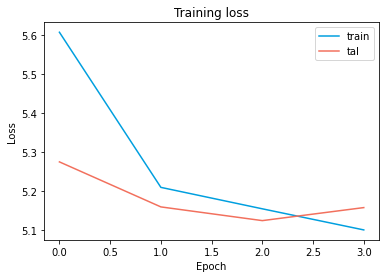

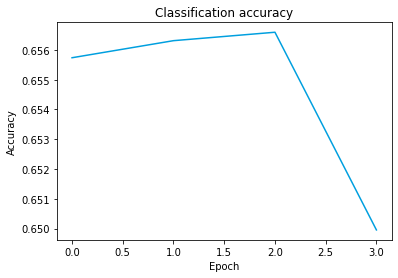

In [12]:
def get_accuracy(preds, labels):
    correct = (np.array(preds) > 0.5) == np.array(labels)
    return np.count_nonzero(correct)/len(correct)

# plot train and val loss over epoch
def plot_train_and_val_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train", color="#009fdf")
    plt.plot(val_loss, label="tal", color="#F2705D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training loss")
    plt.show()

def plot_accuracy(preds, labels):
    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy(epoch_preds, labels))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy, color="#009fdf")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy")
    plt.show()

num_epoch = 4
model_file_path = output_dir + "/"# "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/tr_50_val_5_tst_5_lr_1e-2_BS_100_no_tnets_1_track_add_min_dist/"

# plot train and val loss
loss_data = genfromtxt(model_file_path + "log_loss.csv", delimiter=',').transpose()
loss = loss_data[1]
val_loss = loss_data[2]
plot_train_and_val_loss(loss, val_loss)

# plot test accuracy
labels_unmasked = np.load(model_file_path + "/tests/labels.npy")
labels = labels_unmasked[labels_unmasked != -1]
preds = []
for epoch in range(num_epoch):
    preds_unmasked = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")
    preds.append(preds_unmasked[labels_unmasked != -1])

plot_accuracy(preds, labels)

    